# double_pendulum_validation.ipynb
In this notebook the equations for the double pendulum are developed and validated with the aid of sympy.

The equations are developed using the Euler-Lagrange equations, first for the simple double pendulum, and then for the physical (compound) double pendulum.

The simple double pendulum equations are validated by comparing simulations against a model using equations copy-pasted from the PyDy website: https://www.pydy.org/examples/double_pendulum.html

The physical double pendulum is validated by comparing the equations with three other derivations: 
1. Example 7.4 from: Ardema M.D. "Analytical Dynamics: Theory and Applications" Kluwer Academic/Plenum Publishers, New York, 2005.
2. Section 7.3.2 from: Siciliano B. et al. "Robotics: Modelling, Planning, and Control" Springer, 2008.
3. Equations 3 and 4 from: Hollerbach J.M and Flash T. "Dynamic interactions between limb segments during planar arm movement" Biol. Cybern. 44, 67-77, 1982.

## simple double pendulum using Lagrange's equation with generalized coordinates
The simple double pendulum consists of two two point masses attached to massless rods.

It is assumed that the torques are created by forces perpendicular to the rods applied at the point masses. Generalized forces Q1, Q2 are then created using the approach in chapter 6 of the Ardema 2005 textbook. This leads to a Q1 value that is not merely the torque at the first (shoulder) joint.

Viscous friction is added through extra forces in the Lagrange equations (cf. Ardema 2005 Eq. 6.39).

### Obtaining the Lagrange equations

In [1]:
from sympy import *
import numpy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib widget
init_printing(use_unicode=True)

In [2]:
# create the starting symbols
t = symbols('t')  # symbol for time
θ_1 = Function('θ_1')(t)  # shoulder angle
θ_2 = Function('θ_2')(t)  # elbow angle
L1 = symbols('L1')  # Length of upper arm
L2 = symbols('L2')  # Length of forearm
m1 = symbols('m1')  # "elbow" mass
m2 = symbols('m2')  # "hand" mass
g = symbols('g')  # gravitation constant
τ_1 = symbols('τ_1') # external torque at shoulder
τ_2 = symbols('τ_2') # external torque at elbow
μ_1 = symbols('μ_1') # viscous friction at shoulder
μ_2 = symbols('μ_2') # viscous friction at elbow

In [3]:
x1 = L1 * cos(θ_1)  # elbow x coordinate
y1 = L1 * sin(θ_1)  # elbow y coordinate
x2 = x1 + L2 * cos(θ_1 + θ_2) # hand x coordinate
y2 = y1 + L2 * sin(θ_1 + θ_2) # hand y coordinate

dx1dt = diff(x1, t)
dy1dt = diff(y1, t)
dx2dt = diff(x2, t)
dy2dt = diff(y2, t)

T = Rational(1,2) * (m1 * (dx1dt**2 + dy1dt**2) + m2 * (dx2dt**2 + dy2dt**2)) # kinetic energy
T = simplify(T)
V = m1* g * y1 + m2 * g * y2  # potential energy
L = T-V # Laplacian

# generalized forces
# F is a component vector with the forces creating the torques
F = [(τ_1/(L1**2)) * (-y1), (τ_1/(L1**2)) * (x1), (τ_2/(L2**2)) * (y1-y2), (τ_2/(L2**2)) * (x2-x1)]
Q1 = sum([f * diff(u, θ_1) for f,u in zip(F, [x1,y1,x2,y2])])
Q2 = sum([f * diff(u, θ_2) for f,u in zip(F, [x1,y1,x2,y2])])
Q1 = Q1.simplify()
Q2 = Q2.simplify()

In [4]:
# The Lagrange equations
LE1 = diff(L.diff(diff(θ_1,t)), t) - L.diff(θ_1) - Q1 + μ_1 * diff(θ_1, t)
LE2 = diff(L.diff(diff(θ_2,t)), t) - L.diff(θ_2) - Q2 + μ_2 * diff(θ_2, t)
LE1 = LE1.simplify()
LE2 = LE2.simplify()

### Running simulations, comparing with a double pendulum using the PyDy equations

In [5]:
class double_pendulum:
    """ A double pendulum with the equations derived above.
    """
    def __init__(self, LE1, LE2):
        # solve for the second derivatives of theta_1, theta_2
        sol = solve([LE1, LE2], [diff(diff(θ_1,t),t), diff(diff(θ_2,t),t)])
        d2θ_1dt2 = sol[diff(diff(θ_1,t),t)]
        d2θ_2dt2 = sol[diff(diff(θ_2,t),t)]

        # Substitute the value of the parameters
        self.mass1 = 1.
        self.mass2 = 1.
        self.gravity = 9.8
        self.l1 = 1.
        self.l2 = 1.
        self.mu1 = 0.
        self.mu2 = 0.
        d2θ_1dt2 = d2θ_1dt2.subs([(m1, self.mass1), (m2, self.mass2), (g, self.gravity),
                                  (L1, self.l1), (L2, self.l2), (μ_1, self.mu1), (μ_2, self.mu2)])
        d2θ_2dt2 = d2θ_2dt2.subs([(m1, self.mass1), (m2, self.mass2), (g, self.gravity),
                                  (L1, self.l1), (L2, self.l2), (μ_1, self.mu1), (μ_2, self.mu2)])
        # substitute the first derivatives by dummy symbols
        theta1_p = symbols('theta1_p') # dummy symbol for the first derivative of theta1
        theta2_p = symbols('theta2_p') # dummy symbol for the first derivative of theta2
        d2θ_1dt2 = d2θ_1dt2.subs(diff(θ_1,t), theta1_p)
        d2θ_1dt2 = d2θ_1dt2.subs(diff(θ_2,t), theta2_p)
        d2θ_2dt2 = d2θ_2dt2.subs(diff(θ_1,t), theta1_p)
        d2θ_2dt2 = d2θ_2dt2.subs(diff(θ_2,t), theta2_p)

        # lambdify the second derivatives
        self.theta1_pp = lambdify((θ_1, theta1_p, θ_2, theta2_p, τ_1, τ_2), d2θ_1dt2, "numpy")
        self.theta2_pp = lambdify((θ_1, theta1_p, θ_2, theta2_p, τ_1, τ_2), d2θ_2dt2, "numpy")
        
        # intial conditions
        self.init = [0., 0.1, 0., -0.1]

    def derivatives(self, t, S):
        """ Implementation of the pendulum dynamics using thetaX_pp.
            
            Args:
                S[0] = angle of shoulder [rad]
                S[1] = angular velocity of shoulder [rad/s]
                S[2] = angle of elbow [radians]
                S[3] = elbow's angular velocity [rad/s]
            Returns:
                dsdt[0]: shouler's angular velocity [rad/s]
                dsdt[1]: shoulder's angular acceleration [rad/s^2]
                dsdt[2]: elbow's angular velocity [rad/s]
                dsdt[3]: elbow's angular acceleration [rad/s]
        """
        dsdt = numpy.zeros(4) 
        dsdt[0] = S[1] # shoulder's ang vel
        dsdt[1] = self.theta1_pp(S[0], S[1], S[2], S[3], 0., 0.)
        dsdt[2] = S[3]
        dsdt[3] = self.theta2_pp(S[0], S[1], S[2], S[3], 0., 0.)
        return dsdt
    
    def integrate(self, teval):
        """ Integrate motion equations, returning the solution evaluated at the points teval. """
        T = teval[-1]
        self.solution = solve_ivp(self.derivatives, [0., T], self.init, t_eval=teval)
        

In [6]:
dp = double_pendulum(LE1, LE2)
sim_time = 10.
dp.init = [0., 0., 0., 0.]
teval = numpy.linspace(0., sim_time, 1000)
dp.integrate(teval)

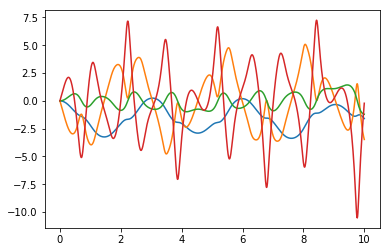

In [7]:
fig = plt.figure()
plt.plot(dp.solution.t, numpy.transpose(dp.solution.y))
#plt.plot(tp.solution.t, th_s, 'b', tp.solution.t, th_e, 'r')

In [8]:
#Animation
%matplotlib widget
from numpy import cos, sin
theta_s = dp.solution.y[0]
theta_e = dp.solution.y[2]
phi = theta_s + theta_e
xe = cos(theta_s)*dp.l1
ye = sin(theta_s)*dp.l1
xh = xe + cos(phi)*dp.l2
yh = ye + sin(phi)*dp.l2

fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
plt.axis('equal')
ax = plt.gca()
lim = dp.l1 + dp.l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()

line, = ax.plot([], [], 'o-b', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    line.set_data(coord_x, coord_y)
    cur_time = frame*0.01
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    return line,

ani = FuncAnimation(fig, update, frames=numpy.arange(0, len(theta_s)), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

In [8]:
class test_pendulum:
    """ A pendulum with equation copy-pasted from:
        http://www.pydy.org/examples/double_pendulum.html
        
        The order of the variables was modified in order to match those
        in draculab's double_pendulum.
    """
    def __init__(self):
        self.g = 9.8 # gravity [m/s^2]
        self.l = 1. # length of each rod
        self.m = 1. # mass of points?
        self.init = [0.5, 1., 0.5, 1.]
        #self.init = [1.5, 0., 0.2, 0.]

    def derivatives(self, t, S):
        """ Copy-pasted equations with order arranged. 
            
            Args:
                S[0] = angle of shoulder [rad]
                S[1] = angular velocity of shoulder [rad/s]
                S[2] = angle of elbow [radians]
                S[3] = elbow's angular velocity [rad/s]
            Returns:
                dsdt[0]: shouler's angular velocity [rad/s]
                dsdt[1]: shoulder's angular acceleration [rad/s^2]
                dsdt[2]: elbow's angular velocity [rad/s]
                dsdt[3]: elbow's angular acceleration [rad/s]
        """
        l = self.l
        g = self.g
        m = self.m
        q1 = S[0]
        q2 = S[2]
        u1 = S[1]
        u2 = S[3]
        dsdt = numpy.zeros(4)
        dsdt[0] = S[1] # shoulder's ang vel
        dsdt[1] = ( (-g*sin(q1)*sin(q2)**2 + 2*g*sin(q1) - g*sin(q2)*cos(q1)*cos(q2) + 
                    2*l*u1**2*sin(q1)*cos(q1)*cos(q2)**2 - l*u1**2*sin(q1)*cos(q1) - 
                    2*l*u1**2*sin(q2)*cos(q1)**2*cos(q2) + l*u1**2*sin(q2)*cos(q2) +
                    l*u2**2*sin(q1)*cos(q2) -
                     l*u2**2*sin(q2)*cos(q1))/(l*(sin(q1)**2*sin(q2)**2 + 2*sin(q1)*sin(q2)*cos(q1)*cos(q2) + cos(q1)**2*cos(q2)**2 - 2)))
        dsdt[2] = S[3]
        dsdt[3] = ( (-sin(q1)*sin(q2)/2 - cos(q1)*cos(q2)/2) * 
                    (2*g*l*m*sin(q1) - l**2*m*(-sin(q1)*cos(q2) + sin(q2)*cos(q1))*u2**2) / 
                    (l**2*m*(sin(q1)*sin(q2)/2 + cos(q1)*cos(q2)/2)*(sin(q1)*sin(q2) + cos(q1)*cos(q2)) - l**2*m) +
                    (g*l*m*sin(q2) - l**2*m*(sin(q1)*cos(q2) - sin(q2)*cos(q1))*u1**2) / 
                    (l**2*m*(sin(q1)*sin(q2)/2 + cos(q1)*cos(q2)/2)*(sin(q1)*sin(q2) + cos(q1)*cos(q2)) - l**2*m) )
        return dsdt
    
    def integrate(self, teval):
        """ Integrate the equations, returning the solution evaluated at the points teval. """
        T = teval[-1]
        self.solution = solve_ivp(self.derivatives, [0., T], self.init, t_eval=teval)
        

In [9]:
# Run test_pendulum with the same parameters
tp = test_pendulum()
#dp_pars = dp_parameters
tp.init = dp.init
tp.init[0] = dp.init[0] + numpy.pi/2.
tp.init[2] = dp.init[2] + tp.init[0]
tp.integrate(teval)

In [10]:
# Convert the angles back to the frame used in draculab
th_s = tp.solution.y[0] - numpy.pi/2.
th_e = tp.solution.y[2] - tp.solution.y[0]

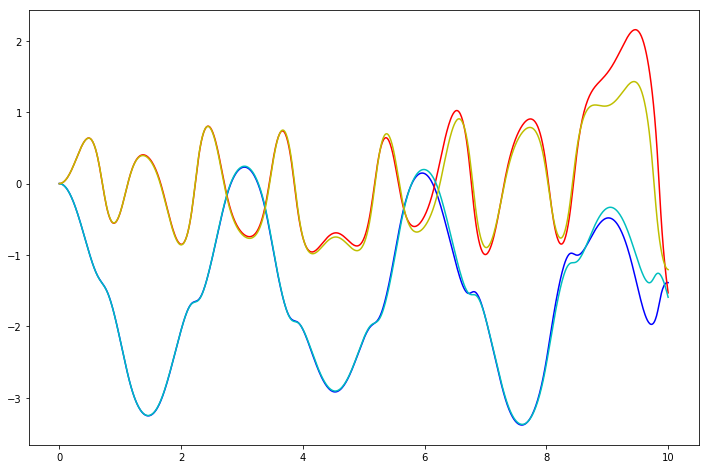

In [11]:
fig = plt.figure(figsize=(12,8))
plt.plot(tp.solution.t, th_s, 'b', tp.solution.t, th_e, 'r')
plt.plot(dp.solution.t, dp.solution.y[0], 'c', dp.solution.t, dp.solution.y[2], 'y')

In [12]:
#Animation
%matplotlib widget
theta_s = th_s
theta_e = th_e
length1 = tp.l
length2 = tp.l
phi = theta_s + theta_e
xe = cos(theta_s)*length1
ye = sin(theta_s)*length1
xh = xe + cos(phi)*length2
yh = ye + sin(phi)*length2

fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
plt.axis('equal')
ax = plt.gca()
ax.set_xlim([-2., 2.])
ax.set_ylim([-2., 2.])
ax.grid()

line, = ax.plot([], [], 'o-b', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    line.set_data(coord_x, coord_y)
    return line,

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s)), init_func=init, blit=True, interval=10)

plt.show()

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'could_extract_minus_sign'

### Printing the equations as code to use in draculab

In [21]:
# Changing the notation in the Lagrange equations in order to print the equations in a format that can be copy-pasted into draculab
# All variables get ASCII names to preserve Python 2 compatibility.
q1, q2, q1p, q2p, q1pp, q2pp, tau1, tau2, mu1, mu2 = symbols("q1, q2, q1p, q2p, q1pp, q2pp, tau1, tau2, mu1, mu2")

LE1s = LE1.subs([(diff(diff(θ_1, t),t), q1pp), (diff(diff(θ_2,t),t), q2pp)])
LE1s = LE1s.subs([(diff(θ_1,t), q1p), (diff(θ_2,t), q2p)])
LE1s = LE1s.subs([(θ_1, q1), (θ_2, q2), (μ_1, mu1)])
LE1s = LE1s.subs([(τ_1, tau1), (τ_2, tau2)])

LE2s = LE2.subs([(diff(diff(θ_1, t),t), q1pp), (diff(diff(θ_2,t),t), q2pp)])
LE2s = LE2s.subs([(diff(θ_1,t), q1p), (diff(θ_2,t), q2p)])
LE2s = LE2s.subs([(θ_1, q1), (θ_2, q2), (τ_1, tau1), (τ_2, tau2), (μ_2, mu2)])

sol = solve([LE1s, LE2s], [q1pp, q2pp])
d2q1dt2 = sol[q1pp]
d2q2dt2 = sol[q2pp]

In [20]:
str(d2q1dt2.simplify())

'(L1**2*L2*m2*q1p**2*sin(2*q2)/2 + L1*L2**2*m2*q1p**2*sin(q2) + 2*L1*L2**2*m2*q1p*q2p*sin(q2) + L1*L2**2*m2*q2p**2*sin(q2) - L1*L2*g*m1*cos(q1) - L1*L2*g*m2*cos(q1)/2 + L1*L2*g*m2*cos(q1 + 2*q2)/2 + L1*mu2*q2p*cos(q2) - L2*mu1*q1p + L2*mu2*q2p + L2*tau1)/(L1**2*L2*(m1 + m2*sin(q2)**2))'

In [19]:
str(d2q2dt2.simplify())

'-(m2*(L1*cos(q2) + L2)*(2*L1*L2**2*m2*q1p*q2p*sin(q2) + L1*L2**2*m2*q2p**2*sin(q2) - L1*L2*g*m1*cos(q1) - L1*L2*g*m2*cos(q1) + L1*tau2*cos(q2) - L2**2*g*m2*cos(q1 + q2) - L2*mu1*q1p + L2*tau1 + L2*tau2) + (L1**2*m1 + L1**2*m2 + 2*L1*L2*m2*cos(q2) + L2**2*m2)*(L1*L2*m2*q1p**2*sin(q2) + L2*g*m2*cos(q1 + q2) + mu2*q2p - tau2))/(L1**2*L2**2*m2*(m1 + m2*sin(q2)**2))'

## Physical double  pendulum

---
### Deriving the Lagrange equations

In [1]:
from sympy import *
import numpy
import numpy as np
#from draculab import *
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
init_printing(use_unicode=True)

In [2]:
# create the starting symbols
t = symbols('t')  # symbol for time
θ_1 = Function('θ_1')(t)  # shoulder angle
θ_2 = Function('θ_2')(t)  # elbow angle
L1 = symbols('L1')  # Length of upper arm
L2 = symbols('L2')  # Length of forearm
m1 = symbols('m1')  # upper arm mass
m2 = symbols('m2')  # forearm mass
g = symbols('g')  # gravitation constant
τ_1 = symbols('τ_1') # external torque at shoulder
τ_2 = symbols('τ_2') # external torque at elbow

In [3]:
x1 = L1 * cos(θ_1)  # elbow x coordinate
y1 = L1 * sin(θ_1)  # elbow y coordinate
x2 = x1 + L2 * cos(θ_1 + θ_2) # hand x coordinate
y2 = y1 + L2 * sin(θ_1 + θ_2) # hand y coordinate
x_c1 = (L1/2.) * cos(θ_1)  # upper arm center of mass x coordinate
y_c1 = (L1/2.) * sin(θ_1)  # upper arm center of mass y coordinate
x_c2 = x1 + (L2/2.) * cos(θ_1 + θ_2) # forearm center of mass x coordinate
y_c2 = y1 + (L2/2.) * sin(θ_1 + θ_2) # forearm center of mass y coordinate

θ_1p = diff(θ_1, t)
θ_2p = diff(θ_2, t)
dx_c2dt = diff(x_c2, t)
dy_c2dt = diff(y_c2, t)

T1 = Rational(1,6) * m1 * L1**2 * θ_1p**2  # upper arm kinetic energy
T2 = (1/2) * m2 * ((dx_c2dt**2 + dy_c2dt**2) + (L2**2/12)*(θ_1p + θ_2p)**2) # forearm KE
T = T1 + T2  # kinetic energy
T = simplify(T)

V = m1*g*y_c1 + m2*g*y_c2  # potential energy
L = T-V # Laplacian

# generalized forces
# F is a component vector with the forces creating the torques
F = [(τ_1/(L1**2)) * (-y1), (τ_1/(L1**2)) * (x1), (τ_2/(L2**2)) * (y1-y2), (τ_2/(L2**2)) * (x2-x1)]
Q1 = sum([f * diff(u, θ_1) for f,u in zip(F, [x1,y1,x2,y2])])
Q2 = sum([f * diff(u, θ_2) for f,u in zip(F, [x1,y1,x2,y2])])
Q1 = Q1.simplify()
Q2 = Q2.simplify()

In [4]:
# The Lagrange equations
LE1 = diff(L.diff(diff(θ_1,t)), t) - L.diff(θ_1) - Q1
LE2 = diff(L.diff(diff(θ_2,t)), t) - L.diff(θ_2) - Q2
#LE1 = LE1.simplify()
#LE2 = LE2.simplify()

### Quick test of the cell above

In [5]:
# Different way to obtain the equations (withouth the torques)
from sympy.calculus.euler import euler_equations
EE1, EE2 = euler_equations(L, [θ_1, θ_2], t)
EE1 = EE1.lhs
EE2 = EE2.lhs

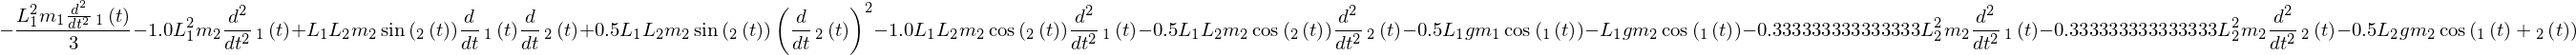

In [6]:
EE1.expand().simplify()

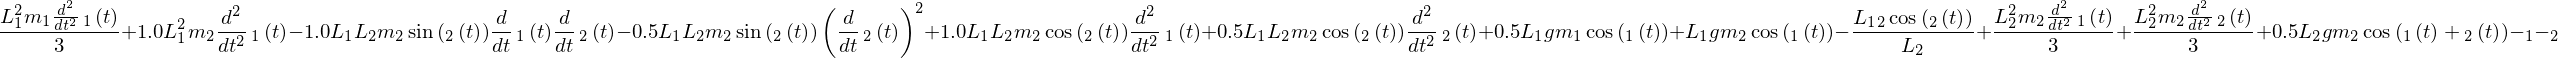

In [7]:
LE1.expand().simplify()

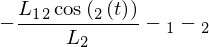

In [8]:
# Result should only include the generalized forces
(EE1+LE1).expand().simplify()

In [9]:
# Result should only include the generalized forces
(EE2+LE2).expand().simplify()

### Solving for the angular accelerations in the LE equations

In [10]:
sol = solve([LE1, LE2], [diff(diff(θ_1,t),t), diff(diff(θ_2,t),t)])
d2θ_1dt2 = sol[diff(diff(θ_1,t),t)]
d2θ_2dt2 = sol[diff(diff(θ_2,t),t)]

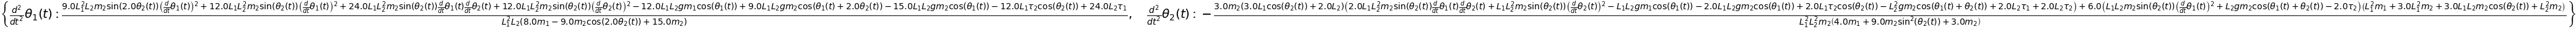

In [11]:
sol

---
### Comparing with Ardema05

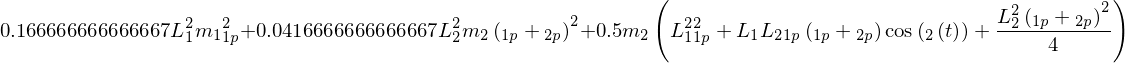

In [5]:
# comparing kinetic energy from Ardema05 (Eq. 7.21)
θ_1p, θ_2p, θ_1pp, θ_2pp, I1, I2 = symbols('θ_1p, θ_2p, θ_1pp, θ_2pp, I1, I2')
l1, l2, Φ, Φp = symbols('l1, l2, Φ, Φp')
AT1 = (1/2) * (m1 * (l1 * θ_1p)**2 + I1 * θ_1p**2)
AT2 = (1/2) * m2 * (L1**2*θ_1p**2 + l2**2*Φp**2 + 2*L1*l2*θ_1p*Φp*cos(Φ - θ_1)) + (1/2) * I2 * Φp**2

AT1 = AT1.subs(l1, L1/2)
AT1 = AT1.subs(I1, (m1*L1**2)/12)
AT2 = AT2.subs(l1, L1/2)
AT2 = AT2.subs(l2, L2/2)
AT2 = AT2.subs(I1, (m1*L1**2)/12)
AT2 = AT2.subs(I2, (m2*L2**2)/12)
AT2 = AT2.subs(Φ, θ_1+θ_2)
AT2 = AT2.subs(Φp, θ_1p+θ_2p)

AT = AT1 + AT2
AT

In [6]:
diff(AT2, θ_1p).simplify()

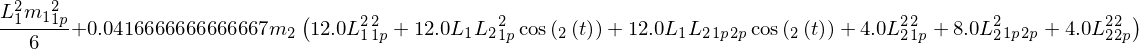

In [7]:
# Changing the notation of T to match cell above
Tn = T.subs(diff(θ_1, t), θ_1p)
Tn = Tn.subs(diff(θ_2, t), θ_2p)
Tn

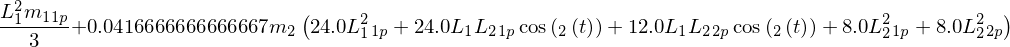

In [8]:
diff(Tn, θ_1p)

In [9]:
# This must be zero!
(Tn-AT).simplify()

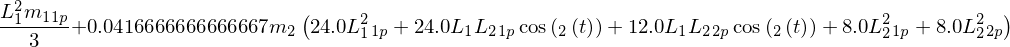

In [10]:
# comparing first derivative of kinetic energy wrt angular velocity
Tndθ_1p = diff(Tn, θ_1p) # derivative of my KE
Tndθ_1p

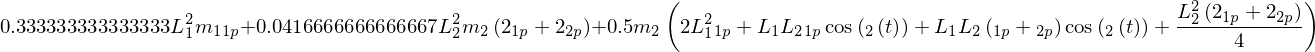

In [11]:
ATdθ_1p = diff(AT, θ_1p) # derivative of Ardema's KE
ATdθ_1p

In [12]:
(ATdθ_1p - Tndθ_1p).simplify()

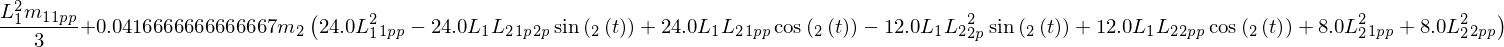

In [13]:
dTdθ_1p = diff(T, diff(θ_1, t))
dTdθ_1pdt = diff(dTdθ_1p, t)
dTdθ_1pdt = dTdθ_1pdt.subs(diff(diff(θ_1,t),t), θ_1pp)
dTdθ_1pdt = dTdθ_1pdt.subs(diff(θ_1,t), θ_1p)
dTdθ_1pdt = dTdθ_1pdt.subs(diff(diff(θ_2,t),t), θ_2pp)
dTdθ_1pdt = dTdθ_1pdt.subs(diff(θ_2,t), θ_2p)
dTdθ_1pdt

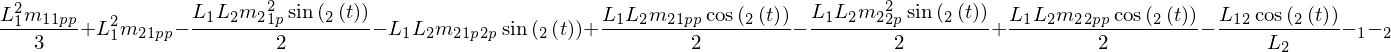

In [14]:
# comparing equations of motion (Eq. 7.25) assuming g=0
Ip, I2e, A = symbols('Ip, I2e, A')
EQ1 = Ip*θ_1pp + A*(θ_2pp+θ_1pp)*cos(θ_2) - A*sin(θ_2)*(θ_1p+θ_2p)**2 - Q1
EQ2 = I2e*(θ_2pp+θ_1pp) + A*θ_1pp*cos(θ_2) + A*sin(θ_2)*θ_1p**2 - Q2

EQ1 = EQ1.subs(Ip, m1*L1**2/3 + m2*L1**2)
EQ1 = EQ1.subs(A, m2*L1*(L2/2))
EQ2 = EQ2.subs(I2e, m2*L2**2/12 + m2*L2**2/4)
EQ2 = EQ2.subs(A, m2*L1*(L2/2))

EQ1.simplify().expand()

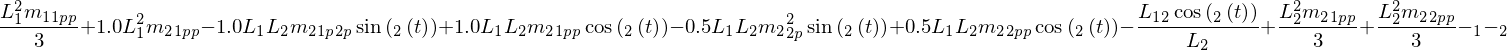

In [15]:
# Changing the notation in the Lagrange equation to match the cell above
LE1s = LE1.subs([(g, 0), (diff(diff(θ_1, t),t), θ_1pp), (diff(diff(θ_2,t),t), θ_2pp)])
LE1s = LE1s.subs([(diff(θ_1,t), θ_1p), (diff(θ_2,t), θ_2p)])
LE2s = LE2.subs([(g, 0), (diff(diff(θ_1, t),t), θ_1pp), (diff(diff(θ_2,t),t), θ_2pp)])
LE2s = LE2s.subs([(diff(θ_1,t), θ_1p), (diff(θ_2,t), θ_2p)])
LE1s.expand().simplify()

Because Ardema05 is using different coordinates, the Euler-Lagrange equations are not supposed to be the same. Nevertheless, they should be related by a nonsingular linear transformation corresponding to the Jacobian matrix of the coordinate transformation. See about invariance of Lagrange's equations in Ardema's section 6.5.  
In this case, the matrix that relates the transformation is:
$\begin{bmatrix}
1 & -1 \\
0 & 1
\end{bmatrix}
$

In [16]:
# This should be zero
(EQ1 - LE1s + LE2s).simplify()

In [17]:
# This should be zero
(EQ2 - LE2s).simplify()

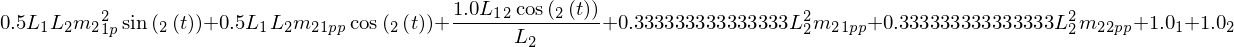

In [18]:
(dTdθ_1pdt - EQ1).simplify()

In [29]:
# Tau from my derivation
sol2 = solve([LE1s, LE2s], [τ_1, τ_2])
myTau1 = sol2[τ_1]
myTau2= sol2[τ_2]
myTau1

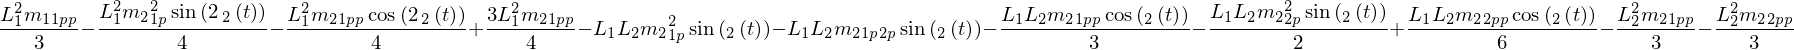

In [28]:
# Tau according to Ardema
Asol = solve([EQ1, EQ2], [τ_1, τ_2])
Atau1 = Asol[τ_1]
Atau2 = Asol[τ_2]
Atau1

In [31]:
(myTau1 - Atau1).simplify()

---
### Simulating and comparing with Draculab

In [5]:
dp_parameters = {'type': plant_models.double_pendulum,
                 'length1': 1.,
                 'length2': 1.,
                 'mass1': 1.,                 
                 'mass2': 1.,
                 'init_angle_s': 0.5,
                 'init_angle_e': 0.5,
                 'init_ang_vel_s': 0.1,
                 'init_ang_vel_e': 0.1}

net_parameters = {'min_delay': 0.01,
                  'min_buff_size': 10}

source_s_parameters = {'init_val' : 0.,
                       'type' : unit_types.source,
                       'function' : lambda x: 0.}

source_e_parameters = {'init_val' : 0.,
                       'type' : unit_types.source,
                       'function' : lambda x: 0.}

net = network(net_parameters)
dp = net.create(1, dp_parameters)
source_s = net.create(1, source_s_parameters) 
source_e = net.create(1, source_e_parameters)

source_s2dp_syn_spec = {'init_w' : 1., 'type' : synapse_types.static}
source_e2dp_syn_spec = {'init_w' : 1., 'type' : synapse_types.static}

source_s2dp_conn_spec = {'inp_ports' : [0], 'delays' : 0.01}
source_e2dp_conn_spec = {'inp_ports' : [1], 'delays' : 0.01}

net.set_plant_inputs(source_s, dp, source_s2dp_conn_spec, source_s2dp_syn_spec)
net.set_plant_inputs(source_e, dp, source_e2dp_conn_spec, source_e2dp_syn_spec)

In [6]:
sim_time = 80. # simulation time
sim_dat = net.run(sim_time)
dp_activs = np.array(sim_dat[2][dp])

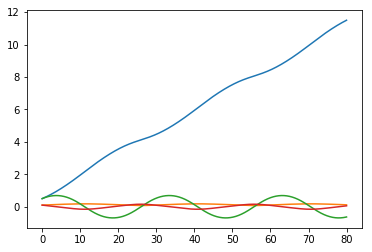

In [7]:
fig = plt.figure()
plt.plot(sim_dat[0], dp_activs)
plt.show()

In [8]:
class double_pendulum:
    """ A double pendulum with the equations derived above.
    """
    def __init__(self, LE1, LE2):
        # solve for the second derivatives of theta_1, theta_2
        sol = solve([LE1, LE2], [diff(diff(θ_1,t),t), diff(diff(θ_2,t),t)])
        d2θ_1dt2 = sol[diff(diff(θ_1,t),t)]
        d2θ_2dt2 = sol[diff(diff(θ_2,t),t)]

        # Substitute the value of the parameters
        self.mass1 = 1.
        self.mass2 = 1.
        self.gravity = 9.8
        self.l1 = 1.
        self.l2 = 1.
        d2θ_1dt2 = d2θ_1dt2.subs([(m1, self.mass1), (m2, self.mass2), (g, self.gravity),
                                  (L1, self.l1), (L2, self.l2)])
        d2θ_2dt2 = d2θ_2dt2.subs([(m1, self.mass1), (m2, self.mass2), (g, self.gravity),
                                  (L1, self.l1), (L2, self.l2)])
        # substitute the first derivatives by dummy symbols
        theta1_p = symbols('theta1_p') # dummy symbol for the first derivative of theta1
        theta2_p = symbols('theta2_p') # dummy symbol for the first derivative of theta2
        d2θ_1dt2 = d2θ_1dt2.subs(diff(θ_1,t), theta1_p)
        d2θ_1dt2 = d2θ_1dt2.subs(diff(θ_2,t), theta2_p)
        d2θ_2dt2 = d2θ_2dt2.subs(diff(θ_1,t), theta1_p)
        d2θ_2dt2 = d2θ_2dt2.subs(diff(θ_2,t), theta2_p)

        # lambdify the second derivatives
        self.theta1_pp = lambdify((θ_1, theta1_p, θ_2, theta2_p, τ_1, τ_2), d2θ_1dt2, "numpy")
        self.theta2_pp = lambdify((θ_1, theta1_p, θ_2, theta2_p, τ_1, τ_2), d2θ_2dt2, "numpy")
        
        # intial conditions
        self.init = [0., 0.1, 0., -0.1]

    def derivatives(self, t, S):
        """ Implementation of the pendulum dynamics using thetaX_pp.
            
            Args:
                S[0] = angle of shoulder [rad]
                S[1] = angular velocity of shoulder [rad/s]
                S[2] = angle of elbow [radians]
                S[3] = elbow's angular velocity [rad/s]
            Returns:
                dsdt[0]: shouler's angular velocity [rad/s]
                dsdt[1]: shoulder's angular acceleration [rad/s^2]
                dsdt[2]: elbow's angular velocity [rad/s]
                dsdt[3]: elbow's angular acceleration [rad/s]
        """
        dsdt = numpy.zeros(4)
        dsdt[0] = S[1] # shoulder's ang vel
        dsdt[1] = self.theta1_pp(S[0], S[1], S[2], S[3], 0., 0.)
        dsdt[2] = S[3]
        dsdt[3] = self.theta2_pp(S[0], S[1], S[2], S[3], 0., 0.)
        return dsdt
    
    def integrate(self, teval):
        """ Integrate motion equations, returning the solution evaluated at the points teval. """
        T = teval[-1]
        self.solution = solve_ivp(self.derivatives, [0., T], self.init, t_eval=teval)
        

In [9]:
dp = double_pendulum(LE1, LE2)
dp.init = [dp_parameters['init_angle_s'],
           dp_parameters['init_ang_vel_s'],
           dp_parameters['init_angle_e'],
           dp_parameters['init_ang_vel_e']]
teval = sim_dat[0]
dp.integrate(teval)

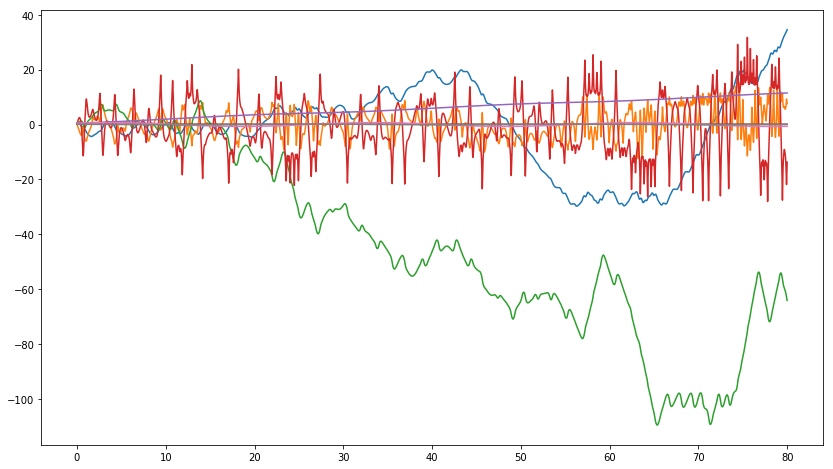

In [10]:
fig = plt.figure(figsize=(14,8))
plt.plot(dp.solution.t, numpy.transpose(dp.solution.y))
plt.plot(sim_dat[0], dp_activs)
plt.show()

In [11]:
#Animation
%matplotlib widget
from numpy import cos, sin
theta_s = dp.solution.y[0]
theta_e = dp.solution.y[2]
phi = theta_s + theta_e
xe = cos(theta_s)*dp.l1
ye = sin(theta_s)*dp.l1
xh = xe + cos(phi)*dp.l2
yh = ye + sin(phi)*dp.l2

fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
plt.axis('equal')
ax = plt.gca()
lim = dp.l1 + dp.l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()

line, = ax.plot([], [], 'o-b', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    line.set_data(coord_x, coord_y)
    cur_time = frame*0.01
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    return line,

ani = FuncAnimation(fig, update, frames=numpy.arange(0, len(theta_s)), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

---
### Comparing equations with Hollerback82 and Siciliano08

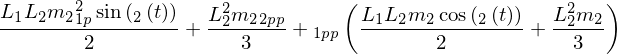

In [19]:
# Equations from Hollerback82
#θ_1p, θ_2p, θ_1pp, θ_2pp, I1, I2 = symbols('θ_1p, θ_2p, θ_1pp, θ_2pp, I1, I2')
n2 = θ_1pp * (I2 + (m2*L1*L2/2)*cos(θ_2) + (m2 * L2**2)/4) + θ_2pp * (I2 + (m2 * L2**2)/4) + (m2 * L1 * L2/2) * (θ_1p**2)*sin(θ_2)
n2 = n2.subs(I1, m1 * L1**2 / 12)
n2 = n2.subs(I2, m2 * L2**2 / 12)
n2

In [20]:
n1 =(θ_1pp * (I1 + I2 + m2*L1*L2*cos(θ_2) + (1/4)*(m1*L1**2 + m2*L2**2) + m2*L1**2) +
     θ_2pp * (I2 + (1/4)*m2*L2**2 + (1/2)*m2*L1*L2*cos(θ_2)) - 
     (1/2)*m2*L1*L2*(θ_2p**2)*sin(θ_2) - 
     m2*L1*L2*θ_1p*θ_2p*sin(θ_2))
#n1 = n1.subs(I1, m1 * L1**2 / 12) # keep I1, I2 to compare with Tau1 below
#n1 = n1.subs(I2, m2 * L2**2 / 12)
n1

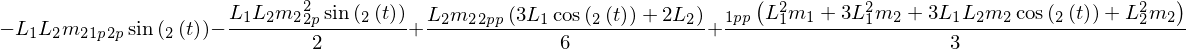

In [21]:
# Equations from Siciliano08
l1, l2 = symbols('l1, l2')
Tau1 = (θ_1pp * (I1 + I2 + m1*l1**2 + m2*(L1**2 + l2**2 + 2*L1*l2*cos(θ_2))) +
        θ_2pp * (I2 + m2*(l2**2 + L1*l2*cos(θ_2))) -
        2 * m2 * L1 * l2 *sin(θ_2) * θ_1p * θ_2p -
        m2 * L1 *l2 * sin(θ_2) * θ_2p**2 +
        g * cos(θ_1) * (m1 * l1 + m2 * L1) +
        m2 * l2 * g * cos(θ_1 + θ_2))
Tau1 = Tau1.subs(l1, L1/2)
Tau1 = Tau1.subs(l2, L2/2)
Tau1.subs(I1, m1 * L1**2 / 12).subs(I2, m2 * L2**2 / 12).subs(g,0).simplify()

In [22]:
# Siciliano and Hollerback agree...
(Tau1.subs(g, 0) - n1).simplify()

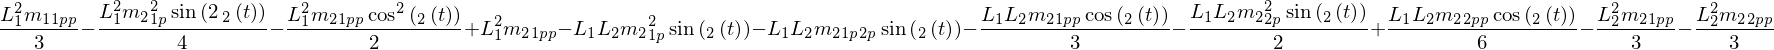

In [23]:
# Comparing Hollerback and Siciliano with Ardema
Asol = solve([EQ1, EQ2], [τ_1, τ_2])
Atau1 = Asol[τ_1]
Atau2 = Asol[τ_2]
expand_trig(Atau1).simplify()

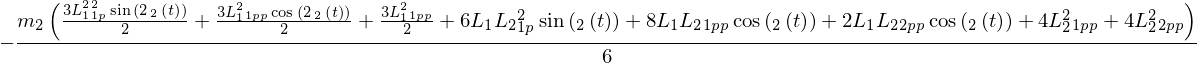

In [24]:
sTau1 = Tau1.subs(I1, m1 * L1**2 / 12).subs(I2, m2 * L2**2 / 12).subs(g,0).simplify()
(expand_trig(Atau1) - sTau1).simplify()

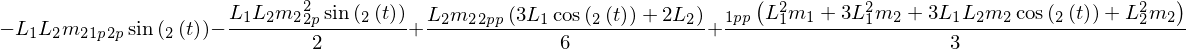

In [32]:
sTau1

In [33]:
myTau1

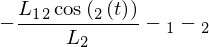

In [42]:
#-------------------------------------------
# THIS IS HOW THE COMPARISION SHOULD BE DONE!
#-------------------------------------------
(LE1s - sTau1).simplify()

In [43]:
str(LE1s)

'L1**2*m1*θ_1pp/3 - L1*τ_2*cos(θ_2(t))/L2 + 0.0416666666666667*m2*(24.0*L1**2*θ_1pp - 24.0*L1*L2*θ_1p*θ_2p*sin(θ_2(t)) + 24.0*L1*L2*θ_1pp*cos(θ_2(t)) - 12.0*L1*L2*θ_2p**2*sin(θ_2(t)) + 12.0*L1*L2*θ_2pp*cos(θ_2(t)) + 8.0*L2**2*θ_1pp + 8.0*L2**2*θ_2pp) - τ_1 - τ_2'

In [27]:
sol2 = solve([LE1s, LE2s], [τ_1, τ_2])
myTau1 = sol2[τ_1]
myTau12= sol2[τ_2]
myTau1

In [28]:
(myTau1 - Atau1).simplify()

In [30]:
(myTau1 - sTau1).simplify()

In [21]:
# Simplifying the equations by substituting variables for concrete values
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2]
n1 = n1.subs(θ_1, vals[0])
n1 = n1.subs(θ_2, vals[1])
n1 = n1.subs(θ_1p, vals[2])
n1 = n1.subs(θ_2p, vals[3])
n1 = n1.subs(θ_1pp, vals[4])
n1 = n1.subs(θ_2pp, vals[5])
n1

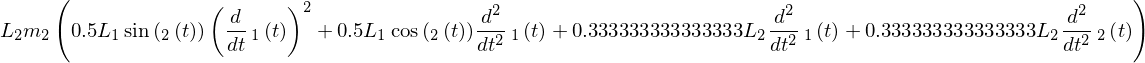

In [22]:
tau2 = sol2[τ_2]
tau2 = tau2.subs(diff(θ_1, t), θ_1p)
tau2 = tau2.subs(diff(θ_2, t), θ_2p)
tau2 = tau2.subs(diff(diff(θ_1p,t), t), θ_1pp)
tau2 = tau2.subs(diff(diff(θ_2p,t), t), θ_2pp)
tau2 = tau2.subs(g, 0)
tau2.simplify()

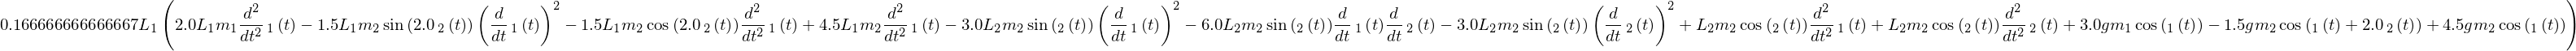

In [23]:
tau1 = sol2[τ_1]
tau1 = tau1.subs(diff(θ_1, t), θ_1p)
tau1 = tau1.subs(diff(θ_2, t), θ_2p)
tau1 = tau1.subs(diff(diff(θ_1p,t), t), θ_1pp)
tau1 = tau1.subs(diff(diff(θ_2p,t), t), θ_2pp)
#tau1 = tau1.subs(g, 0)
tau1.simplify()

In [24]:
tau1 = tau1.subs(diff(diff(θ_2(t),t),t), vals[5])
tau1 = tau1.subs(diff(diff(θ_1(t),t),t), vals[4])
tau1 = tau1.subs(diff(θ_2(t),t), vals[3])
tau1 = tau1.subs(diff(θ_1(t),t), vals[2])
tau1 = tau1.subs(θ_1(t), vals[0])
tau1 = tau1.subs(θ_2(t), vals[1])
tau1.simplify().expand()